In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy  as np
import sklearn
import re
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ĐỒ ÁN NLP/IMDB Dataset.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Tiền xử lý dữ liệu

In [ ]:
# Check if there are any duplicates
dup = data.duplicated().sum()
print(f'Có {dup} giá trị bị trùng lặp')

Có 418 giá trị bị trùng lặp


In [ ]:
# Drop the duplicates
data = data.drop_duplicates(subset = 'review')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


positive    24884
negative    24698
Name: sentiment, dtype: int64


(array([0, 1]), [Text(0, 0, 'negative'), Text(1, 0, 'positive')])

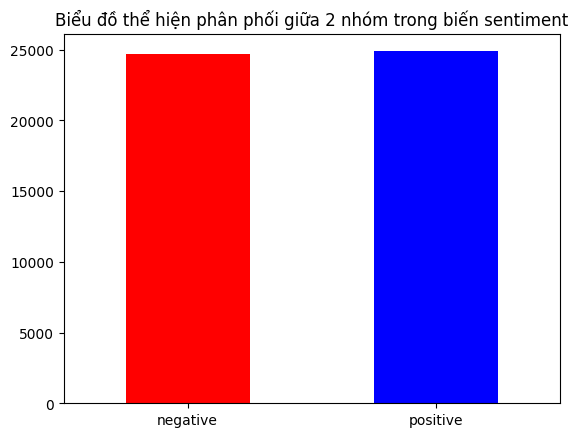

In [ ]:
# Data distribution
rating_counts = data['sentiment'].value_counts()
print(rating_counts)

data['sentiment'].value_counts().sort_index().plot.bar(color=['red', 'blue'])
plt.title('Biểu đồ thể hiện phân phối giữa 2 nhóm trong biến sentiment')
plt.xticks(rotation = 0)

In [ ]:
# The shape of data
data.shape

(49582, 2)

#Tiền xử lý

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Stopwords in English
stop_words = stopwords.words('english')
len(stop_words)

179

In [ ]:
# Remove the negative words in stopwords
negative_words=['no','not',"don't","aren't","couldn't",
                "didn't","doesn't","hadn't","hasn't","haven't",
                "isn't","mightn't","mustn't","needn't","shouldn't",
                "wasn't","weren't","won't","wouldn't"]
for negative_word in negative_words:
    if negative_word in stop_words:
        stop_words.remove(negative_word)

print("Stopwords sau khi loại bỏ những từ negative:",len(stop_words))

Stopwords sau khi loại bỏ những từ negative: 160


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}—[]|@,;‘?|।!-॥–’-]')

def clean_text(sample):
    if isinstance(sample, str):  # Check if sample is a string or not
        sample = sample.lower()
        sample = sample.replace("<br /><br />", "")
        sample = REPLACE_BY_SPACE_RE.sub(' ', sample)
        sample = re.sub("[^a-z]+", " ", sample)
        sample = sample.split(" ")
        sample = [word for word in sample if word not in stop_words]
        sample = " ".join(sample)
        return sample
    else:
        return ''

In [ ]:
# Process text, remove unwanted characters and unnecessary words
data['review'] = data['review'].apply(clean_text)
data.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


In [ ]:
def remove_emoji(text):
    return re.sub(r'[^\w\s,]', '', str(text)) if isinstance(text, str) else text

# Apply remove_emoji function for 'review' column in DataFrame
data['review'] = data['review'].apply(remove_emoji)

In [ ]:
# Tokenize and lemmatize text
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)
data

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


#Naive Bayes

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
from sklearn.model_selection import train_test_split
# Input
x = data['review'].values
# Output
y = data['sentiment'].values

# Train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

print(f"Kích thước của dữ liệu huấn luyện: {X_train.shape[0]}.")
print(f"Kích thước của dữ liệu thử nghiệm: {X_test.shape[0]}.")

Kích thước của dữ liệu huấn luyện: 39665.
Kích thước của dữ liệu thử nghiệm: 9917.


#### Count Vectorizer

In [ ]:
# Make pipeline with CountVectorizer and MultinomialNB
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
# Experience with different alpha values
parameters = {'multinomialnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
# Perform GridSearchCV
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

# Get the best alpha value
best_alpha_cv = grid.best_params_['multinomialnb__alpha']
print(f'Best alpha with Count Vectorizer: {best_alpha_cv}')

Best alpha with Count Vectorizer: 1.5


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# Make pipeline with CountVectorizer and MultinomialNB with optimized alpha
nb_model_cv = make_pipeline(CountVectorizer(), MultinomialNB(alpha=best_alpha_cv))

# Train the model with training dataset
nb_model_cv.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=1.5))])

In [ ]:
nb_accuracy = nb_model_cv.score(X_test, y_test)
print(f'Độ chính xác của mô hình Naive Bayes với Count Vectorizer: {round(nb_accuracy*100)}%')

Độ chính xác của mô hình Naive Bayes với Count Vectorizer: 86%


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict on test set
nb_predictions = nb_model_cv.predict(X_test)

# Calculate and print the evaluation scores
accuracy = accuracy_score(y_test, nb_predictions)
print(f'Accuracy: {accuracy:.3f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, nb_predictions))

Accuracy: 0.862
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.88      0.86      4940
    positive       0.88      0.84      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



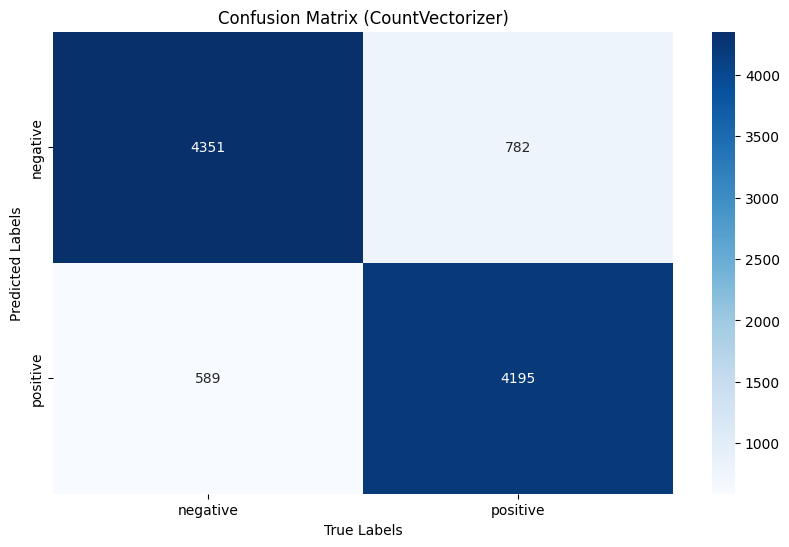

In [ ]:
# Confusion matrix
import seaborn as sns
matrix = confusion_matrix(nb_predictions,y_test)
matrix_df = pd.DataFrame(matrix, index=np.unique(y), columns=np.unique(y))
plt.figure(figsize=(10,6))
plt.tight_layout(pad=2.0)
sns.heatmap(matrix_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Confusion Matrix (CountVectorizer)")
plt.show()

#### TF-IDF Vectorizer

In [ ]:
# Make pipeline with TfidfVectorizer and MultinomialNB
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Experience with different alpha values
parameters = {'multinomialnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
# Perform GridSearchCV
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

# Get the best alpha value
best_alpha_tf = grid.best_params_['multinomialnb__alpha']
print(f'Best alpha with TF-IDF Vectorizer: {best_alpha_tf}')

Best alpha with TF-IDF Vectorizer: 1.5


In [ ]:
# Make pipeline with TF-IDF and MultinomialNB with optimized alpha
nb_model_tf = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=best_alpha_tf))

# Train the model with training dataset
nb_model_tf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=1.5))])

In [ ]:
nb_accuracy = nb_model_tf.score(X_test, y_test)
print(f'Độ chính xác của mô hình Naive Bayes với TF-IDF: {round(nb_accuracy*100)}%')

Độ chính xác của mô hình Naive Bayes với TF-IDF: 87%


In [ ]:
# Predict on test set
nb_pre = nb_model_tf.predict(X_test)
# Calculate and print the evaluation scores
accuracy_tf = accuracy_score(y_test, nb_pre)
print(f'Accuracy: {accuracy_tf:.3f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, nb_pre))

Accuracy: 0.868
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      4940
    positive       0.88      0.85      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



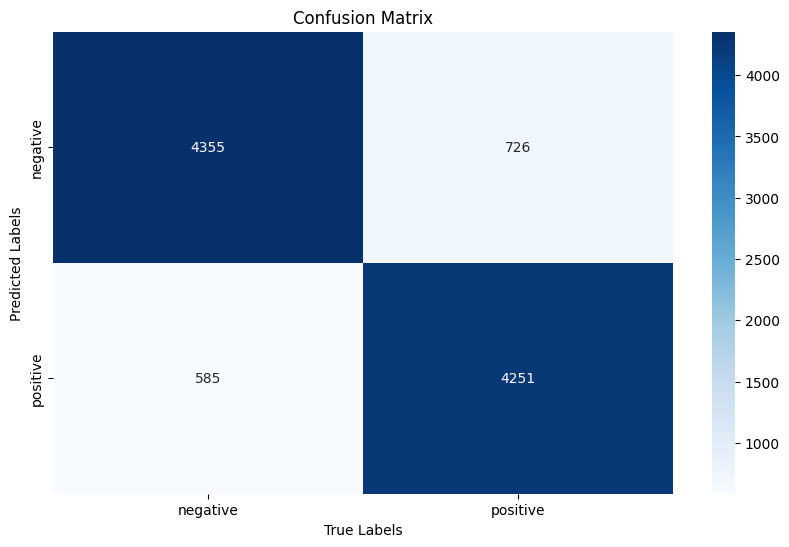

In [ ]:
# Confusion matrix
import seaborn as sns
matrix_tf = confusion_matrix(nb_pre,y_test)
matrix_tf = pd.DataFrame(matrix_tf, index=np.unique(y), columns=np.unique(y))
plt.figure(figsize=(10,6))
plt.tight_layout(pad=2.0)
sns.heatmap(matrix_tf, annot=True, cmap="Blues", fmt="d")
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Confusion Matrix")
plt.show()

#Maxent

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Count Vectorizer

In [ ]:
# Make pipeline with CountVectorizer and Logistic Regression
pipeline = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000))

# Experience with different values of C
parameters = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform GridSearchCV
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

# Get the best C value
best_C_cv = grid.best_params_['logisticregression__C']
print(f'Best C with Count Vectorizer: {best_C_cv}')

Best C with Count Vectorizer: 0.1


In [ ]:
# Train model with best C value
lr_model_cv = make_pipeline(CountVectorizer(), LogisticRegression(C=best_C_cv, max_iter=1000))
lr_model_cv.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

In [ ]:
# Evaluate the model accuracy
lr_accuracy_cv = lr_model_cv.score(X_test, y_test)
print(f'Độ chính xác của mô hình: {lr_accuracy_cv*100}%')

Độ chính xác của mô hình: 89.0188565090249%


In [ ]:
# Predict on test set
predictions_cv = lr_model_cv.predict(X_test)

# Print classification report
print(classification_report(y_test, predictions_cv))

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      4940
    positive       0.89      0.89      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [ ]:
# Total predictions
total_predictions_cv = len(predictions_cv)
# Number of correct predictions
correct_predictions_cv = sum(predictions_cv == y_test)
# Number of incorrect predictions
incorrect_predictions_cv = total_predictions_cv - correct_predictions_cv
# Result
print(f'Tổng số dự đoán của mô hình: {total_predictions_cv}')
print(f'Số dự đoán đúng: {correct_predictions_cv}')
print(f'Số dự đoán sai: {incorrect_predictions_cv}')

Tổng số dự đoán của mô hình: 9917
Số dự đoán đúng: 8828
Số dự đoán sai: 1089


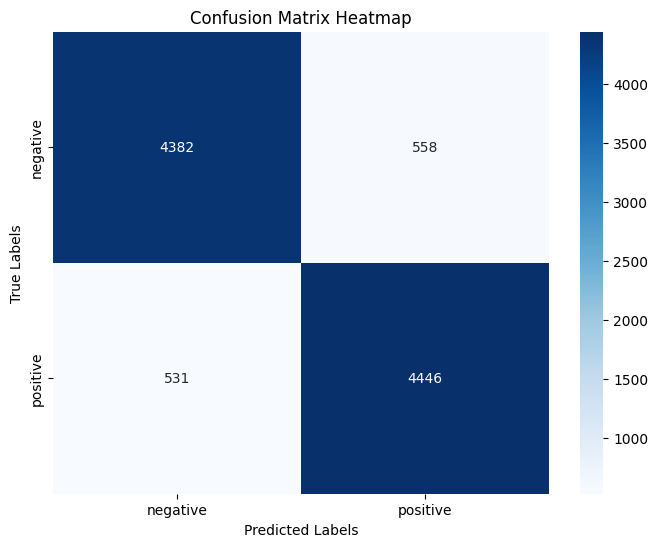

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_cv)

# Create heatmap from confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model_cv.classes_, yticklabels=lr_model_cv.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

#### TF-IDF Vectorizer

In [ ]:
# Make pipeline with CountVectorizer and Logistic Regression
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

# Experience with different values of C
parameters = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
# Perform GridSearchCV
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

# Get the best C value
best_C_tf = grid.best_params_['logisticregression__C']
print(f'Best C with TF-IDF Vectorizer: {best_C_tf}')

Best C with TF-IDF Vectorizer: 10


In [ ]:
# Train model with best C value
lr_model_tf = make_pipeline(TfidfVectorizer(), LogisticRegression(C=best_C_tf, max_iter=1000))
lr_model_tf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000))])

In [ ]:
# Evaluate the model accuracy
lr_accuracy_tf = lr_model_tf.score(X_test, y_test)
print(f'Độ chính xác của mô hình: {lr_accuracy_tf*100}%')

Độ chính xác của mô hình: 89.58354341030554%


In [ ]:
# Predict on test set
predictions_tf = lr_model_tf.predict(X_test)

# Print classification report
print(classification_report(y_test, predictions_tf))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      4940
    positive       0.89      0.90      0.90      4977

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



In [ ]:
# Total predictions
total_predictions_tf = len(predictions_tf)
# Number of correct predictions
correct_predictions_tf = sum(predictions_tf == y_test)
# Number of incorrect predictions
incorrect_predictions_tf = total_predictions_tf - correct_predictions_tf
# Result
print(f'Tổng số dự đoán của mô hình: {total_predictions_tf}')
print(f'Số dự đoán đúng: {correct_predictions_tf}')
print(f'Số dự đoán sai: {incorrect_predictions_tf}')

Tổng số dự đoán của mô hình: 9917
Số dự đoán đúng: 8884
Số dự đoán sai: 1033


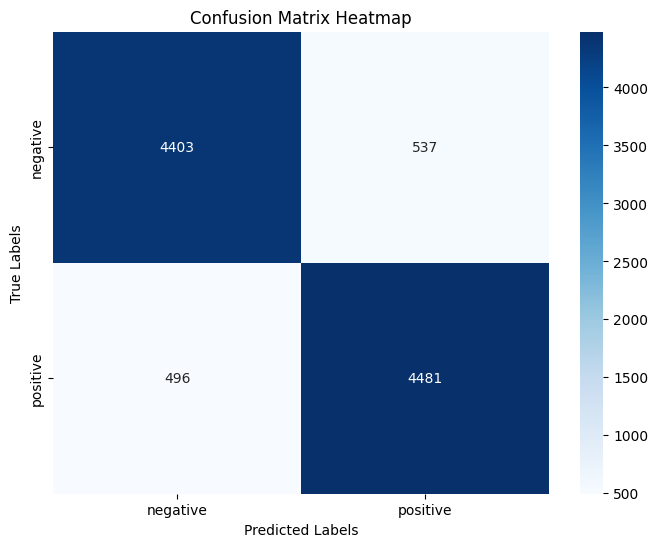

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_tf)

# Create heatmap from confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model_tf.classes_, yticklabels=lr_model_tf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

#Tfidf Vectorizer & Count Vectorizer

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
cv_log = Pipeline([
('cv', CountVectorizer()),
('lr', LogisticRegression(C = best_C_cv, max_iter=1000))])
cv_log.fit(X_train, y_train)
cv_log.score(X_train, y_train), cv_log.score(X_test, y_test)

(0.9637211647548216, 0.890188565090249)

In [ ]:
cv_mnb = Pipeline([
('cv', CountVectorizer()),
('mnb', MultinomialNB(alpha = best_alpha_cv))])
cv_mnb.fit(X_train, y_train)
cv_mnb.score(X_train, y_train), cv_mnb.score(X_test, y_test)

(0.896508256649439, 0.8617525461329031)

In [ ]:
tf_log = Pipeline([
('tf', TfidfVectorizer()),
('lr', LogisticRegression(C = best_C_tf, max_iter = 1000))])
tf_log.fit(X_train, y_train)
tf_log.score(X_train, y_train), tf_log.score(X_test, y_test)

(0.982125299382327, 0.8958354341030553)

In [ ]:
tf_mnb = Pipeline([
('tf', TfidfVectorizer()),
('mnb', MultinomialNB(alpha = best_alpha_tf))])
tf_mnb.fit(X_train, y_train)
tf_mnb.score(X_train, y_train), tf_mnb.score(X_test, y_test)

(0.9013740073112315, 0.8678027629323384)

In [ ]:
def classifier_metrics(report_title, model):
  preds = model.predict(X_test)
  train_accuracy = model.score(X_train, y_train)
  test_accuracy = accuracy_score(y_test, preds)
  metrics = {
  'model': report_title,
  'train_accuracy': train_accuracy,
  'test_accuracy': test_accuracy,
  }
  df = pd.DataFrame(metrics.items()).T
  df.columns = df.iloc[0]
  df = df[1:]
  return df


In [ ]:
metrics1 = classifier_metrics('CountVectorizer + Multinomial Logistic Regression', cv_log)
metrics2 = classifier_metrics('TF-IDF + Multinomial Logistic Regression', tf_log)
metrics3 = classifier_metrics('CountVectorizer + Multinomial Naive Bayes', cv_mnb)
metrics4 = classifier_metrics('TF-IDF + Multinomial Naive Bayes', tf_mnb)
metrics = pd.concat([metrics1, metrics2, metrics3, metrics4]).sort_values('test_accuracy')
metrics

,model,train_accuracy,test_accuracy
1,CountVectorizer + Multinomial Naive Bayes,0.896508,0.861753
1,TF-IDF + Multinomial Naive Bayes,0.901374,0.867803
1,CountVectorizer + Multinomial Logistic Regression,0.963721,0.890189
1,TF-IDF + Multinomial Logistic Regression,0.982125,0.895835


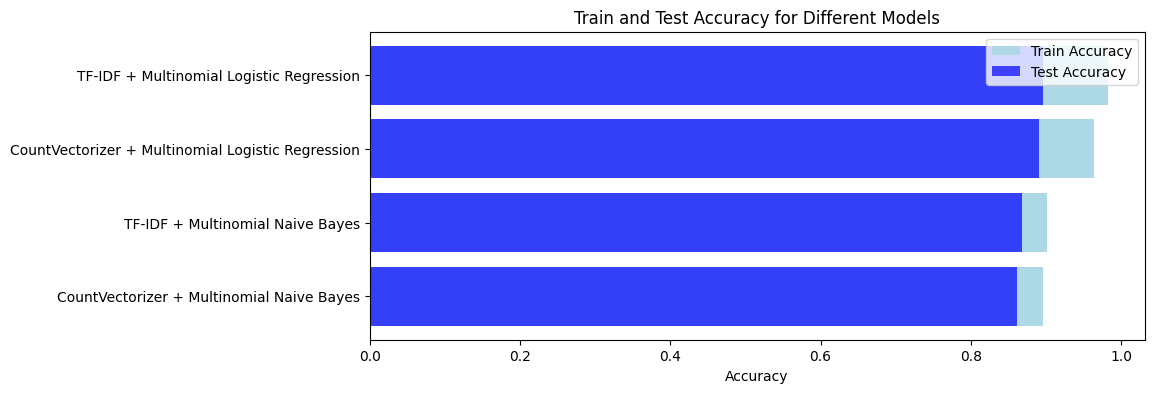

In [ ]:
# Create chart
fig, ax = plt.subplots(figsize=(10, 4))

# Train accuracy
ax.barh(metrics['model'], metrics['train_accuracy'], color='lightblue', label='Train Accuracy')

# Test accuracy
ax.barh(metrics['model'], metrics['test_accuracy'], color='blue', alpha=0.7, label='Test Accuracy')

# Set label and title
ax.set_xlabel('Accuracy')
ax.set_title('Train and Test Accuracy for Different Models')

# Show legend
ax.legend()

# Show the graph
plt.show()

#Mô hình học sâu

In [ ]:
reviews = data['review']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

# Get the total number of unique words in the vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Print the vocabulary size and embedding dimension
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 91737


In [ ]:
s = 0.0
for i in data['review']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/data.shape[0])

Average length of each review :  119.96399903190674


In [ ]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, test_size = 0.2, stratify = encoded_labels)

In [ ]:
# Hyperparameters of the model
vocab_size = 3000
oov_tok = ''
embedding_dim = 200
max_length = 200
padding_type='post'
trunc_type='post'

# Tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# Convert test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [ ]:
# Model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 200)          600000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               135680    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 24)                3096      
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 738801 (2.82 MB)
Trainable params: 738801 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
num_epochs = 5
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1,
                    validation_split=0.1)

Epoch 1/5
1116/1116 [==============================] - 535s 475ms/step - loss: 0.4024 - accuracy: 0.8170 - val_loss: 0.3326 - val_accuracy: 0.8611
Epoch 2/5
1116/1116 [==============================] - 526s 471ms/step - loss: 0.2848 - accuracy: 0.8850 - val_loss: 0.3208 - val_accuracy: 0.8704
Epoch 3/5
1116/1116 [==============================] - 522s 468ms/step - loss: 0.2473 - accuracy: 0.9030 - val_loss: 0.3030 - val_accuracy: 0.8682
Epoch 4/5
1116/1116 [==============================] - 508s 455ms/step - loss: 0.2659 - accuracy: 0.8937 - val_loss: 0.3182 - val_accuracy: 0.8664
Epoch 5/5
1116/1116 [==============================] - 502s 450ms/step - loss: 0.2152 - accuracy: 0.9152 - val_loss: 0.3504 - val_accuracy: 0.8699


In [ ]:
history_df = pd.DataFrame(history.history)

# Add an 'epoch' column to the DataFrame
history_df.insert(0, 'epoch', history_df.index + 1)

# Display the DataFrame
history_df

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.402381,0.817049,0.332596,0.861104
1,2,0.284774,0.885008,0.320779,0.870431
2,3,0.247295,0.902992,0.303025,0.868162
3,4,0.265901,0.893692,0.318157,0.866398
4,5,0.215198,0.915205,0.350386,0.869927


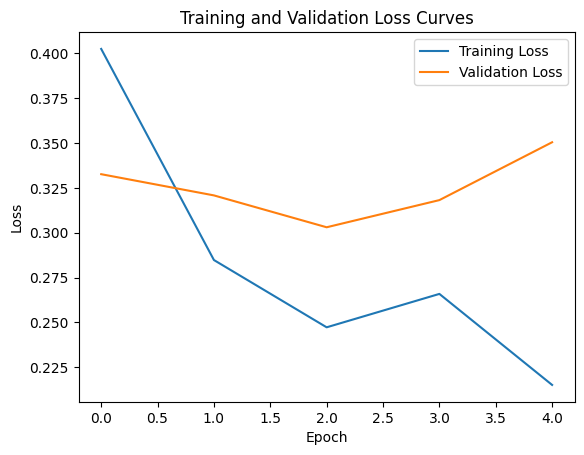

In [ ]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')

# Add a legend
plt.legend()

# Show the plot
plt.show()

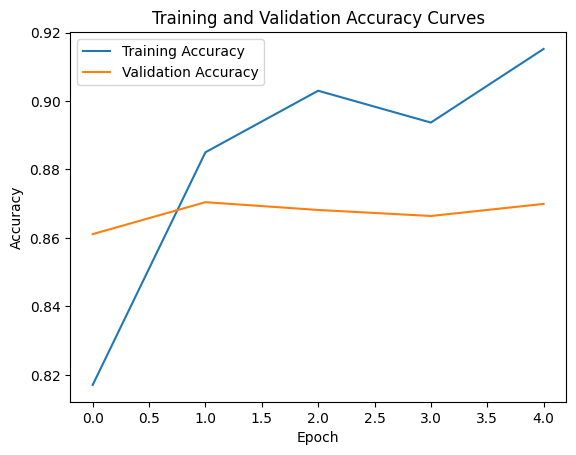

In [ ]:
# Plot training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

310/310 [==============================] - 38s 118ms/step
Accuracy of prediction on test set :  0.8750630230916607


In [ ]:
print(classification_report(test_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4940
           1       0.87      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917

